<a href="https://colab.research.google.com/github/FranciscoAguiar/DataScienceProgramming/blob/master/Classificadores2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
sns.set_style('whitegrid')
import tensorflow as tf
from sklearn.model_selection import train_test_split, cross_val_predict, TimeSeriesSplit, cross_val_score,cross_val_predict
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix,r2_score, precision_score, recall_score, f1_score,cohen_kappa_score
import time
import warnings
from collections import Counter
from imblearn.over_sampling import ADASYN
warnings.filterwarnings("ignore", category=DeprecationWarning)
import shap
%matplotlib inline

SMALL_SIZE = 10
MEDIUM_SIZE = 12

plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=MEDIUM_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rcParams['figure.dpi']=150

In [2]:
!pip install shap

     |████████████████████████████████| 356 kB 5.2 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491649 sha256=a01e7b890443ff5854ad917bdb965e40d1918030e6be9520f29de75fbc002cd7
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap


# Data Acquisition

In [4]:
dataset = pd.read_csv('combined.csv', sep=',')
datasetLi = pd.read_csv('combinedLIWC.csv', sep=',')
datasetCo = pd.read_csv('combined_CohMetrix.csv', sep=',')

In [5]:
dataset.describe()

,id,classe
count,1000.000000,1000.000000
mean,8887.011000,0.890000
std,4957.123671,0.313046
min,20.000000,0.000000
25%,1649.750000,1.000000
50%,11987.000000,1.000000
75%,12796.750000,1.000000
max,13814.000000,1.000000


In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        1000 non-null   int64 
 1   feedback  996 non-null    object
 2   classe    1000 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 23.6+ KB


In [7]:
dataset.shape

(1000, 3)

In [8]:
dataset["classe"].value_counts()

1    890
0    110
Name: classe, dtype: int64

# Desbalanceamento

Class 0: 110
Class 1: 890
Proportion: 0.12 : 1


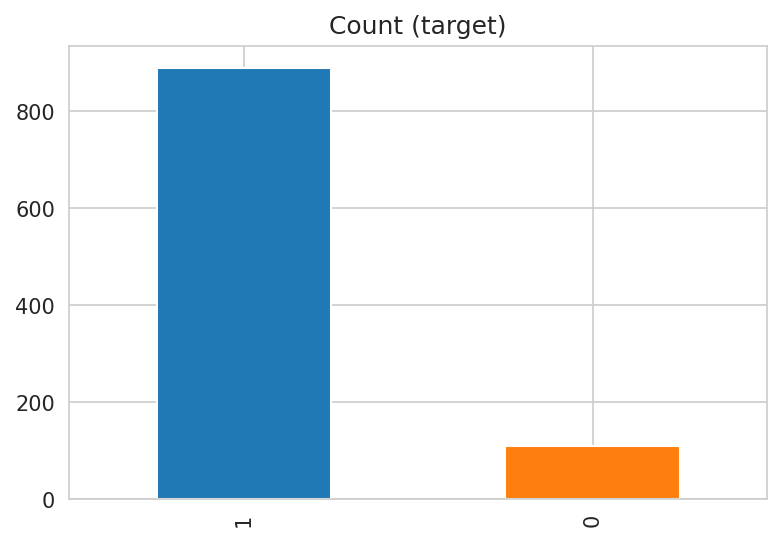

In [9]:
target_count = dataset.classe.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')
target_count.plot(kind='bar', title='Count (target)',color = ['#1F77B4', '#FF7F0E']);

# Data Exploration

In [10]:
dataset.head(20)

,id,feedback,classe
0,23,Ler outros textos sobre o assunto para lher da...,0
1,24,Procure ler mais; para escrever mais acerca do...,0
2,35,Texto bom; precisa apenas ler mais um pouco; p...,0
3,37,Ter cuidado com copias da internet.,0
4,68,Carssimo; o trabalho precisa de uma sistematiz...,1
5,286,Ol Wilma! Na sua postagem no consta o nom...,0
6,665,Faltaram alguns elementos: referncias etc.,0
7,804,Bom dia Ana Lcia! De acordo com a tarefa da we...,1
8,842,Boa tarde Ccero! o motivo da sua pontuao foi i...,1
9,1098,Bom dia!!! cuidado com os erros ortogrficos e ...,0


In [11]:
datasetCo.tail()

,ID,cm.DESPC,cm.DESSC,cm.DESWC,cm.DESPL,cm.DESPLd,cm.DESSL,cm.DESSLd,cm.DESWLsy,cm.DESWLsyd,cm.DESWLlt,cm.DESWLltd,cm.CRFNO1,cm.CRFAO1,cm.CRFSO1,cm.CRFNOa,cm.CRFAOa,cm.CRFSOa,cm.CRFCWO1,cm.CRFCWO1d,cm.CRFCWOa,cm.CRFCWOad,cm.CRFANP1,cm.CRFANPa,cm.LSASS1,cm.LSASS1d,cm.LSASSp,cm.LSASSpd,cm.LSAPP1,cm.LSAPP1d,cm.LSAGN,cm.LSAGNd,cm.LDTTRc,cm.LDTTRa,cm.LDMTLDa,cm.LDVOCDa,cm.CNCAll,cm.CNCCaus,cm.CNCLogic,cm.CNCADC,...,cm.SMCAUSv,cm.SMCAUSvp,cm.SMCAUSr,cm.SMCAUSlsa,cm.SMCAUSwn,cm.SYNLE,cm.SYNMEDpos,cm.SYNMEDwrd,cm.SYNMEDlem,cm.SYNSTRUTa,cm.SYNSTRUTt,cm.DRNP,cm.DRVP,cm.DRAP,cm.DRPP,cm.DRPVAL,cm.DRNEG,cm.DRGERUND,cm.DRINF,cm.WRDNOUN,cm.WRDVERB,cm.WRDADJ,cm.WRDADV,cm.WRDPRO,cm.WRDPRP1s,cm.WRDPRP1p,cm.WRDPRP2,cm.WRDPRP3s,cm.WRDPRP3p,cm.WRDFRQc,cm.WRDFRQa,cm.WRDFRQmc,cm.WRDAOAc,cm.WRDFAMc,cm.WRDCNCc,cm.WRDIMGc,cm.WRDMEAc,cm.RDFRE,cm.RDFKGL,cm.RDL2
995,13809,1,2,28,2.0,0.0,12.000000,11.000000,2.250000,1.404358,5.625000,3.603384,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0,0,0.0,0.0,0.0,0.0,0,0,0.250000,0.433013,1.000000,0.956522,148.12,0.00000,1.0,1.0,2.0,0.0,...,0.0,1.0,1.0,0.250000,1.0,0.333333,1.000000,1.0,1.0,0.000000,0.000000,0,0,0,0,0,0,0,1,5,1,4,1,0,0,0,0,0,0,6.163387,1.818627,5.906580,477.500000,592.384615,270.666667,291.153846,320.909091,-13.320000,18.098333,86.123599
996,13810,1,2,66,2.0,0.0,29.500000,27.500000,1.969697,1.149845,5.000000,2.810392,0,0,0,0,0,0,0.038624,0.029450,0.036554,0.040336,0,0,0.0,0.0,0.0,0.0,0,0,0.250000,0.433013,0.969697,0.850000,112.00,0.88498,3.0,1.0,3.0,0.0,...,0.0,1.0,1.0,0.250000,4.0,3.000000,0.807407,1.0,1.0,0.000000,0.000000,1,2,0,0,0,0,0,3,19,7,5,2,2,0,0,0,0,0,6.181342,1.821535,5.762268,427.333333,572.047619,313.500000,339.571429,334.562500,0.523008,20.515000,84.936501
997,13811,1,2,37,2.0,0.0,16.500000,15.500000,2.027027,1.213042,4.969697,2.876075,1,1,1,1,1,1,0.078125,0.078125,0.052083,0.073657,1,1,0.0,0.0,0.0,0.0,0,0,0.250000,0.433013,0.941176,0.818182,50.82,0.00000,3.0,2.0,3.0,0.0,...,1.0,3.0,1.0,0.250000,2.0,1.333333,1.000000,1.0,1.0,0.000000,0.000000,1,0,0,0,0,0,0,0,10,2,3,2,3,0,0,0,0,0,6.300706,1.840662,6.300706,384.571429,583.000000,285.450000,298.666667,317.888889,8.069318,16.232879,98.955636
998,13813,1,3,28,3.0,0.0,7.666667,10.143416,1.964286,1.170063,5.086957,2.764889,0,0,0,0,0,0,0.022727,0.022727,0.015152,0.021427,0,0,0.0,0.0,0.0,0.0,0,0,0.111111,0.314270,1.000000,0.956522,148.12,0.00000,1.0,1.0,1.0,0.0,...,1.0,2.0,0.5,0.111111,2.0,1.000000,0.950000,1.0,1.0,0.490914,0.490914,1,0,0,0,0,0,0,0,8,2,5,0,2,0,0,0,0,0,6.096397,1.807698,5.301215,426.000000,592.285714,223.142857,246.857143,298.857143,15.140290,13.052174,103.964498
999,13814,1,3,28,3.0,0.0,7.666667,10.143416,2.000000,1.217161,5.173913,2.792103,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0,0,0.0,0.0,0.0,0.0,0,0,0.111111,0.314270,1.000000,0.956522,148.12,0.00000,1.0,1.0,1.0,0.0,...,1.0,2.0,0.5,0.111111,2.0,0.000000,0.666667,1.0,1.0,0.420973,0.420973,1,0,0,0,0,0,0,0,8,2,5,0,2,0,0,0,0,0,6.066792,1.802830,5.275471,426.000000,592.285714,223.142857,246.857143,298.857143,11.462029,13.565217,97.918037


In [13]:
datasetCo['classe'] = dataset['classe']
datasetCo.head()

,ID,cm.DESPC,cm.DESSC,cm.DESWC,cm.DESPL,cm.DESPLd,cm.DESSL,cm.DESSLd,cm.DESWLsy,cm.DESWLsyd,cm.DESWLlt,cm.DESWLltd,cm.CRFNO1,cm.CRFAO1,cm.CRFSO1,cm.CRFNOa,cm.CRFAOa,cm.CRFSOa,cm.CRFCWO1,cm.CRFCWO1d,cm.CRFCWOa,cm.CRFCWOad,cm.CRFANP1,cm.CRFANPa,cm.LSASS1,cm.LSASS1d,cm.LSASSp,cm.LSASSpd,cm.LSAPP1,cm.LSAPP1d,cm.LSAGN,cm.LSAGNd,cm.LDTTRc,cm.LDTTRa,cm.LDMTLDa,cm.LDVOCDa,cm.CNCAll,cm.CNCCaus,cm.CNCLogic,cm.CNCADC,...,cm.SMCAUSvp,cm.SMCAUSr,cm.SMCAUSlsa,cm.SMCAUSwn,cm.SYNLE,cm.SYNMEDpos,cm.SYNMEDwrd,cm.SYNMEDlem,cm.SYNSTRUTa,cm.SYNSTRUTt,cm.DRNP,cm.DRVP,cm.DRAP,cm.DRPP,cm.DRPVAL,cm.DRNEG,cm.DRGERUND,cm.DRINF,cm.WRDNOUN,cm.WRDVERB,cm.WRDADJ,cm.WRDADV,cm.WRDPRO,cm.WRDPRP1s,cm.WRDPRP1p,cm.WRDPRP2,cm.WRDPRP3s,cm.WRDPRP3p,cm.WRDFRQc,cm.WRDFRQa,cm.WRDFRQmc,cm.WRDAOAc,cm.WRDFAMc,cm.WRDCNCc,cm.WRDIMGc,cm.WRDMEAc,cm.RDFRE,cm.RDFKGL,cm.RDL2,classe
0,23,1,1,18,1.0,0.0,17.0,0.000000,1.888889,0.900254,5.117647,2.193100,0,0,0,0,0,0,NaN,NaN,0.000000,0.000000,0,0,0.000000,0.0,NaN,NaN,0,0,1.000000,0.000000,0.900000,0.882353,40.46,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.000000,1.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,2,5,2,2,1,0,0,0,0,0,0,6.132208,1.813555,6.132208,464.666667,559.000000,356.142857,339.285714,336.250000,25.356471,13.945882,NaN,0
1,24,1,2,24,2.0,0.0,10.5,0.500000,1.916667,1.100066,5.095238,2.670915,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0,0,0.393322,0.0,0.393322,0.000000,0,0,0.696661,0.303339,0.923077,0.952381,123.48,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.674710,6.0,0.50,0.833333,0.916667,0.916667,0.000000,0.000000,0,2,0,0,0,0,0,5,3,7,0,3,0,0,0,0,0,0,6.640197,1.893142,6.308187,375.000000,588.666667,303.000000,323.444444,346.000000,27.485000,11.910000,95.041286,0
2,35,1,2,31,2.0,0.0,12.5,0.500000,1.741935,0.964978,5.040000,2.424541,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0,0,0.135975,0.0,0.135975,0.000000,0,0,0.567988,0.432012,1.000000,0.960000,175.00,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.766387,5.0,0.25,0.944444,1.000000,1.000000,0.000000,0.000000,1,3,0,0,0,0,0,4,5,6,2,3,0,0,0,0,0,0,6.633897,1.892192,6.357485,403.000000,590.090909,312.333333,339.818182,375.000000,32.505000,11.706667,96.135954,0
3,37,1,1,7,1.0,0.0,6.0,0.000000,1.857143,1.069045,4.833333,2.266912,0,0,0,0,0,0,NaN,NaN,0.000000,0.000000,0,0,0.000000,0.0,NaN,NaN,0,0,1.000000,0.000000,1.000000,1.000000,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.000000,1.0,1.00,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,6.600221,1.887103,6.600221,269.000000,561.000000,422.500000,413.500000,349.500000,31.545000,10.350000,NaN,0
4,68,1,4,32,4.0,0.0,6.5,3.640055,1.937500,1.268413,5.500000,3.388328,0,0,0,0,0,0,0.020833,0.029463,0.019189,0.027286,0,0,0.000000,0.0,0.023908,0.053461,0,0,0.142931,0.327327,1.000000,0.920000,87.50,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.122583,2.0,1.25,1.000000,1.000000,1.000000,0.855264,0.855264,1,2,0,0,0,0,0,1,8,5,1,0,0,0,0,0,0,0,6.422688,1.859837,5.138150,486.000000,599.444444,245.375000,264.666667,293.571429,17.755250,12.335500,122.581573,1


In [18]:
datasetCo.drop(columns=['ID'],inplace=True)
datasetCo.head()

,cm.DESPC,cm.DESSC,cm.DESWC,cm.DESPL,cm.DESPLd,cm.DESSL,cm.DESSLd,cm.DESWLsy,cm.DESWLsyd,cm.DESWLlt,cm.DESWLltd,cm.CRFNO1,cm.CRFAO1,cm.CRFSO1,cm.CRFNOa,cm.CRFAOa,cm.CRFSOa,cm.CRFCWO1,cm.CRFCWO1d,cm.CRFCWOa,cm.CRFCWOad,cm.CRFANP1,cm.CRFANPa,cm.LSASS1,cm.LSASS1d,cm.LSASSp,cm.LSASSpd,cm.LSAPP1,cm.LSAPP1d,cm.LSAGN,cm.LSAGNd,cm.LDTTRc,cm.LDTTRa,cm.LDMTLDa,cm.LDVOCDa,cm.CNCAll,cm.CNCCaus,cm.CNCLogic,cm.CNCADC,cm.CNCTemp,...,cm.SMCAUSvp,cm.SMCAUSr,cm.SMCAUSlsa,cm.SMCAUSwn,cm.SYNLE,cm.SYNMEDpos,cm.SYNMEDwrd,cm.SYNMEDlem,cm.SYNSTRUTa,cm.SYNSTRUTt,cm.DRNP,cm.DRVP,cm.DRAP,cm.DRPP,cm.DRPVAL,cm.DRNEG,cm.DRGERUND,cm.DRINF,cm.WRDNOUN,cm.WRDVERB,cm.WRDADJ,cm.WRDADV,cm.WRDPRO,cm.WRDPRP1s,cm.WRDPRP1p,cm.WRDPRP2,cm.WRDPRP3s,cm.WRDPRP3p,cm.WRDFRQc,cm.WRDFRQa,cm.WRDFRQmc,cm.WRDAOAc,cm.WRDFAMc,cm.WRDCNCc,cm.WRDIMGc,cm.WRDMEAc,cm.RDFRE,cm.RDFKGL,cm.RDL2,classe
0,1,1,18,1.0,0.0,17.0,0.000000,1.888889,0.900254,5.117647,2.193100,0,0,0,0,0,0,NaN,NaN,0.000000,0.000000,0,0,0.000000,0.0,NaN,NaN,0,0,1.000000,0.000000,0.900000,0.882353,40.46,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.000000,1.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,2,5,2,2,1,0,0,0,0,0,0,6.132208,1.813555,6.132208,464.666667,559.000000,356.142857,339.285714,336.250000,25.356471,13.945882,NaN,0
1,1,2,24,2.0,0.0,10.5,0.500000,1.916667,1.100066,5.095238,2.670915,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0,0,0.393322,0.0,0.393322,0.000000,0,0,0.696661,0.303339,0.923077,0.952381,123.48,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.674710,6.0,0.50,0.833333,0.916667,0.916667,0.000000,0.000000,0,2,0,0,0,0,0,5,3,7,0,3,0,0,0,0,0,0,6.640197,1.893142,6.308187,375.000000,588.666667,303.000000,323.444444,346.000000,27.485000,11.910000,95.041286,0
2,1,2,31,2.0,0.0,12.5,0.500000,1.741935,0.964978,5.040000,2.424541,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0,0,0.135975,0.0,0.135975,0.000000,0,0,0.567988,0.432012,1.000000,0.960000,175.00,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.766387,5.0,0.25,0.944444,1.000000,1.000000,0.000000,0.000000,1,3,0,0,0,0,0,4,5,6,2,3,0,0,0,0,0,0,6.633897,1.892192,6.357485,403.000000,590.090909,312.333333,339.818182,375.000000,32.505000,11.706667,96.135954,0
3,1,1,7,1.0,0.0,6.0,0.000000,1.857143,1.069045,4.833333,2.266912,0,0,0,0,0,0,NaN,NaN,0.000000,0.000000,0,0,0.000000,0.0,NaN,NaN,0,0,1.000000,0.000000,1.000000,1.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.000000,1.0,1.00,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,6.600221,1.887103,6.600221,269.000000,561.000000,422.500000,413.500000,349.500000,31.545000,10.350000,NaN,0
4,1,4,32,4.0,0.0,6.5,3.640055,1.937500,1.268413,5.500000,3.388328,0,0,0,0,0,0,0.020833,0.029463,0.019189,0.027286,0,0,0.000000,0.0,0.023908,0.053461,0,0,0.142931,0.327327,1.000000,0.920000,87.50,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.122583,2.0,1.25,1.000000,1.000000,1.000000,0.855264,0.855264,1,2,0,0,0,0,0,1,8,5,1,0,0,0,0,0,0,0,6.422688,1.859837,5.138150,486.000000,599.444444,245.375000,264.666667,293.571429,17.755250,12.335500,122.581573,1


In [19]:
datasetCurrent = datasetCo

In [20]:
datasetCurrent.columns

Index(['cm.DESPC', 'cm.DESSC', 'cm.DESWC', 'cm.DESPL', 'cm.DESPLd', 'cm.DESSL',
       'cm.DESSLd', 'cm.DESWLsy', 'cm.DESWLsyd', 'cm.DESWLlt', 'cm.DESWLltd',
       'cm.CRFNO1', 'cm.CRFAO1', 'cm.CRFSO1', 'cm.CRFNOa', 'cm.CRFAOa',
       'cm.CRFSOa', 'cm.CRFCWO1', 'cm.CRFCWO1d', 'cm.CRFCWOa', 'cm.CRFCWOad',
       'cm.CRFANP1', 'cm.CRFANPa', 'cm.LSASS1', 'cm.LSASS1d', 'cm.LSASSp',
       'cm.LSASSpd', 'cm.LSAPP1', 'cm.LSAPP1d', 'cm.LSAGN', 'cm.LSAGNd',
       'cm.LDTTRc', 'cm.LDTTRa', 'cm.LDMTLDa', 'cm.LDVOCDa', 'cm.CNCAll',
       'cm.CNCCaus', 'cm.CNCLogic', 'cm.CNCADC', 'cm.CNCTemp', 'cm.CNCAdd',
       'cm.CNCPos', 'cm.CNCNeg', 'cm.CNCAlter', 'cm.CNCConclu', 'cm.CNCExpli',
       'cm.CNCConce', 'cm.CNCCondi', 'cm.CNCConfor', 'cm.CNCFinal',
       'cm.CNCProp', 'cm.CNCComp', 'cm.CNCConse', 'cm.CNCInte', 'cm.SMCAUSv',
       'cm.SMCAUSvp', 'cm.SMCAUSr', 'cm.SMCAUSlsa', 'cm.SMCAUSwn', 'cm.SYNLE',
       'cm.SYNMEDpos', 'cm.SYNMEDwrd', 'cm.SYNMEDlem', 'cm.SYNSTRUTa',
       'cm.SYNSTRUT

In [21]:
pd.options.display.max_columns = None

In [22]:
datasetCurrent.isna().sum(axis=0)

cm.DESPC        0
cm.DESSC        0
cm.DESWC        0
cm.DESPL        0
cm.DESPLd       0
             ... 
cm.WRDMEAc      0
cm.RDFRE        0
cm.RDFKGL       0
cm.RDL2       165
classe          0
Length: 95, dtype: int64

In [23]:
datasetCurrent.isnull().sum(axis = 1)

0      5
1      0
2      0
3      5
4      0
      ..
995    0
996    0
997    0
998    0
999    0
Length: 1000, dtype: int64

In [24]:
datasetCurrent.isnull().sum().sort_values(ascending = False)

cm.LSASSp      362
cm.LSASSpd     362
cm.CRFCWO1     165
cm.CRFCWO1d    165
cm.RDL2        165
              ... 
cm.DRNP          0
cm.DRVP          0
cm.DRAP          0
cm.DRPP          0
cm.DESPC         0
Length: 95, dtype: int64

In [34]:
datasetCurrent.dropna(subset = ["cm.RDL2","cm.LSASSp", "cm.LSASSpd"] , inplace=True)

In [35]:
datasetCurrent.describe()

,cm.DESPC,cm.DESSC,cm.DESWC,cm.DESPL,cm.DESPLd,cm.DESSL,cm.DESSLd,cm.DESWLsy,cm.DESWLsyd,cm.DESWLlt,cm.DESWLltd,cm.CRFNO1,cm.CRFAO1,cm.CRFSO1,cm.CRFNOa,cm.CRFAOa,cm.CRFSOa,cm.CRFCWO1,cm.CRFCWO1d,cm.CRFCWOa,cm.CRFCWOad,cm.CRFANP1,cm.CRFANPa,cm.LSASS1,cm.LSASS1d,cm.LSASSp,cm.LSASSpd,cm.LSAPP1,cm.LSAPP1d,cm.LSAGN,cm.LSAGNd,cm.LDTTRc,cm.LDTTRa,cm.LDMTLDa,cm.LDVOCDa,cm.CNCAll,cm.CNCCaus,cm.CNCLogic,cm.CNCADC,cm.CNCTemp,cm.CNCAdd,cm.CNCPos,cm.CNCNeg,cm.CNCAlter,cm.CNCConclu,cm.CNCExpli,cm.CNCConce,cm.CNCCondi,cm.CNCConfor,cm.CNCFinal,cm.CNCProp,cm.CNCComp,cm.CNCConse,cm.CNCInte,cm.SMCAUSv,cm.SMCAUSvp,cm.SMCAUSr,cm.SMCAUSlsa,cm.SMCAUSwn,cm.SYNLE,cm.SYNMEDpos,cm.SYNMEDwrd,cm.SYNMEDlem,cm.SYNSTRUTa,cm.SYNSTRUTt,cm.DRNP,cm.DRVP,cm.DRAP,cm.DRPP,cm.DRPVAL,cm.DRNEG,cm.DRGERUND,cm.DRINF,cm.WRDNOUN,cm.WRDVERB,cm.WRDADJ,cm.WRDADV,cm.WRDPRO,cm.WRDPRP1s,cm.WRDPRP1p,cm.WRDPRP2,cm.WRDPRP3s,cm.WRDPRP3p,cm.WRDFRQc,cm.WRDFRQa,cm.WRDFRQmc,cm.WRDAOAc,cm.WRDFAMc,cm.WRDCNCc,cm.WRDIMGc,cm.WRDMEAc,cm.RDFRE,cm.RDFKGL,cm.RDL2,classe
count,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000
mean,0.987461,3.192790,45.542320,3.192790,-0.006270,12.137553,7.634259,1.893486,1.211756,5.164325,3.212586,0.144201,0.274295,0.246082,0.609718,1.396552,0.952978,0.017076,0.013897,0.015992,0.018958,0.144201,0.609718,0.145849,0.045431,0.141966,0.052705,-0.006270,-0.006270,0.417947,0.387132,0.947109,0.875367,85.824905,0.256607,0.796238,0.841693,1.278997,0.163009,0.047022,0.815047,5.744514,0.509404,0.072100,0.134796,0.871473,0.813480,0.449843,0.318182,0.843260,-0.006270,0.829154,0.804075,1.180251,1.321317,2.163009,0.360242,0.267222,3.918495,1.743316,0.873985,0.977410,0.972604,0.316235,0.316235,1.206897,2.145768,0.164577,0.083072,0.916928,-0.006270,0.222571,1.043887,9.835423,5.827586,2.753918,1.832288,2.007837,0.010972,-0.006270,-0.006270,0.031348,0.007837,6.327153,1.833654,5.725294,344.124391,580.048909,277.102511,293.438197,312.805768,20.997505,13.282738,103.504241,0.934169
std,0.157988,3.029237,41.149045,3.029237,0.078994,5.887039,5.645273,0.324123,0.675913,0.958506,2.038822,0.442509,0.687405,0.598750,2.046485,6.565534,2.987832,0.084498,0.083330,0.083333,0.083742,0.442509,2.046485,0.182284,0.119272,0.176373,0.119035,0.078994,0.078994,0.202404,0.132295,0.165810,0.169656,61.494221,0.411843,1.058353,1.674919,1.763194,0.413749,0.246130,1.115170,7.033153,0.869367,0.333111,0.438363,1.729539,1.677632,1.016269,0.658728,1.746189,0.078994,1.719944,1.671870,2.209680,1.667460,3.029693,0.689433,0.203076,3.898992,1.515123,0.190515,0.159408,0.159999,0.342594,0.342594,1.415706,2.659494,0.510055,0.328158,1.446371,0.078994,0.604009,2.236690,7.593449,6.540903,2.750300,2.729873,3.540517,0.162994,0.078994,0.078994,0.228891,0.142642,0.620813,0.227944,0.704027,157.222919,63.501784,47.083735,47.129721,45.928956,22.489567,3.910859,23.767156,0.248181
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0

In [36]:
datasetCurrent['classe'].value_counts()

1    596
0     42
Name: classe, dtype: int64

In [37]:
datasetCurrent.columns.values

array(['cm.DESPC', 'cm.DESSC', 'cm.DESWC', 'cm.DESPL', 'cm.DESPLd',
       'cm.DESSL', 'cm.DESSLd', 'cm.DESWLsy', 'cm.DESWLsyd', 'cm.DESWLlt',
       'cm.DESWLltd', 'cm.CRFNO1', 'cm.CRFAO1', 'cm.CRFSO1', 'cm.CRFNOa',
       'cm.CRFAOa', 'cm.CRFSOa', 'cm.CRFCWO1', 'cm.CRFCWO1d',
       'cm.CRFCWOa', 'cm.CRFCWOad', 'cm.CRFANP1', 'cm.CRFANPa',
       'cm.LSASS1', 'cm.LSASS1d', 'cm.LSASSp', 'cm.LSASSpd', 'cm.LSAPP1',
       'cm.LSAPP1d', 'cm.LSAGN', 'cm.LSAGNd', 'cm.LDTTRc', 'cm.LDTTRa',
       'cm.LDMTLDa', 'cm.LDVOCDa', 'cm.CNCAll', 'cm.CNCCaus',
       'cm.CNCLogic', 'cm.CNCADC', 'cm.CNCTemp', 'cm.CNCAdd', 'cm.CNCPos',
       'cm.CNCNeg', 'cm.CNCAlter', 'cm.CNCConclu', 'cm.CNCExpli',
       'cm.CNCConce', 'cm.CNCCondi', 'cm.CNCConfor', 'cm.CNCFinal',
       'cm.CNCProp', 'cm.CNCComp', 'cm.CNCConse', 'cm.CNCInte',
       'cm.SMCAUSv', 'cm.SMCAUSvp', 'cm.SMCAUSr', 'cm.SMCAUSlsa',
       'cm.SMCAUSwn', 'cm.SYNLE', 'cm.SYNMEDpos', 'cm.SYNMEDwrd',
       'cm.SYNMEDlem', 'cm.SYNSTRUTa', 'cm.S

In [ ]:
le = LabelEncoder()
dataset["feedback"] = le.fit_transform(dataset["feedback"].astype(str))
str_cols = dataset.columns[dataset.columns.str.contains('(?:feedback)')]
clfs = {c:LabelEncoder() for c in str_cols}

for col, clf in clfs.items():
    dataset[col] = clfs[col].fit_transform(dataset[col])

# Machine Learning Models - Training

In [38]:
def cross_validation_result(model,X_train,y_train, X_test, y_test,cv_split=10):
    
    tscv = TimeSeriesSplit(cv_split)
    training_score = cross_val_score(model,X_train,y_train,cv=tscv.n_splits) 
    testing_score = cross_val_score(model,X_test,y_test,cv=tscv.n_splits)
    print("Cross-val Training score:", training_score.mean())
    print("Cross-val Testing score:", testing_score.mean())
    training_predictions = cross_val_predict(model,X_train,y_train,cv=tscv.n_splits)
    testing_predictions = cross_val_predict(model,X_test,y_test,cv=tscv.n_splits)
    
    training_accuracy = r2_score(y_train,training_predictions) 
    test_accuracy = r2_score(y_test,testing_predictions)
    
    print ("Training-predictions accuracy:",training_accuracy)  
    print ("Test-predictions accuracy:",test_accuracy)

    f1_score_model = f1_score(y_test, testing_predictions, average="macro")
    print("F1 score",f1_score_model)
    precision_score_model = precision_score(y_test, testing_predictions, average="macro")
    print("Precision score",precision_score_model)
    recall_score_model = recall_score(y_test, testing_predictions, average="macro")
    print("Recall score",recall_score_model)
    return training_accuracy,test_accuracy,f1_score_model,precision_score_model,recall_score_model


In [39]:
scaler = MinMaxScaler()
sdss = scaler.fit_transform(datasetCurrent.drop('classe', axis=1))

In [40]:
X_train, X_test, y_train, y_test = train_test_split(sdss, datasetCurrent['classe'], test_size=0.33)

In [41]:
counter = Counter(y_train)
print(counter)

Counter({1: 396, 0: 31})


In [42]:
counter = Counter(y_test)
print(counter)

Counter({1: 200, 0: 11})


In [43]:
oversample = ADASYN()
X_train, y_train = oversample.fit_resample(X_train, y_train)
X_test, y_test = oversample.fit_resample(X_test, y_test)

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.


In [44]:
counter = Counter(y_train)
print(counter)

Counter({1: 396, 0: 390})


In [45]:
counter = Counter(y_test)
print(counter)

Counter({1: 200, 0: 200})


*K Nearest Neighbors¶*

In [46]:
knn = KNeighborsClassifier()
training_start = time.perf_counter()
knn.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = knn.predict(X_test)
prediction_end = time.perf_counter()
acc_knn = (preds == y_test).sum().astype(float) / len(preds)*100
kappa_knn = cohen_kappa_score(preds,y_test,weights='quadratic')
training_acc_knn, testing_acc_knn,f1_score_knn,precision_score_knn,recall_score_knn= cross_validation_result(knn,X_train,y_train,X_test,y_test)
knn_train_time = training_end-training_start
knn_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's K Nearest Neighbors Classifier's prediction accuracy is: %3.2f" % (acc_knn))
print("kappa_knn", kappa_knn)  
print("Time consumed for training: %4.3f seconds" % (knn_train_time))
print("Time consumed for prediction: %6.5f seconds" % (knn_prediction_time))

Cross-val Training score: 0.8868711457319053
Cross-val Testing score: 0.9225
Training-predictions accuracy: 0.547047397047397
Test-predictions accuracy: 0.69
F1 score 0.9220317029156371
Precision score 0.9329004329004329
Recall score 0.9225
Scikit-Learn's K Nearest Neighbors Classifier's prediction accuracy is: 88.25
kappa_knn 0.765
Time consumed for training: 0.009 seconds
Time consumed for prediction: 0.05823 seconds


*Naive Bayes*

In [47]:
#from sklearn.preprocessing import MaxAbsScaler
#scaler_gnb = MaxAbsScaler()
#sdss = scaler_gnb.fit_transform(datasetCurrent.drop('classe', axis=1))
#X_train_gnb, X_test_gnb, y_train_gnb, y_test_gnb = train_test_split(sdss, datasetCurrent['classe'], test_size=0.33)

gnb = GaussianNB()
training_start = time.perf_counter()
gnb.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = gnb.predict(X_test)
prediction_end = time.perf_counter()
acc_gnb = (preds == y_test).sum().astype(float) / len(preds)*100
kappa_gnb = cohen_kappa_score(preds,y_test,weights='quadratic')
training_acc_gnb, testing_acc_gnb,f1_score_gnb,precision_score_gnb,recall_score_gnb = cross_validation_result(gnb,X_train,y_train,X_test,y_test)
gnb_train_time = training_end-training_start
gnb_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's Gaussian Naive Bayes Classifier's prediction accuracy is: %3.2f" % (acc_gnb))
print("kappa_gnb", kappa_gnb)
print("Time consumed for training: %4.3f seconds" % (gnb_train_time))
print("Time consumed for prediction: %6.5f seconds" % (gnb_prediction_time))

Cross-val Training score: 0.7672995780590718
Cross-val Testing score: 0.5725
Training-predictions accuracy: 0.0686480186480185
Test-predictions accuracy: -0.71
F1 score 0.4822535595067784
Precision score 0.7394517380893403
Recall score 0.5725
Scikit-Learn's Gaussian Naive Bayes Classifier's prediction accuracy is: 87.25
kappa_gnb 0.745
Time consumed for training: 0.002 seconds
Time consumed for prediction: 0.00684 seconds


*XGBoost*

In [48]:
xgb = XGBClassifier(n_estimators=100)
training_start = time.perf_counter()
xgb.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = xgb.predict(X_test)
prediction_end = time.perf_counter()
acc_xgb = (preds == y_test).sum().astype(float) / len(preds)*100
kappa_xgb = cohen_kappa_score(preds,y_test,weights='quadratic')
training_acc_xgb, testing_acc_xgb,f1_score_xgb,precision_score_xgb,recall_score_xgb = cross_validation_result(xgb,X_train,y_train,X_test,y_test)
xgb_train_time = training_end-training_start
xgb_prediction_time = prediction_end-prediction_start
print("XGBoost's prediction accuracy is: %3.2f" % (acc_xgb))
print("kappa_xgb", kappa_xgb)
print("Time consumed for training: %4.3f" % (xgb_train_time))
print("Time consumed for prediction: %6.5f seconds" % (xgb_prediction_time))

Cross-val Training score: 0.9796656929568321
Cross-val Testing score: 0.97
Training-predictions accuracy: 0.9185703185703186
Test-predictions accuracy: 0.88
F1 score 0.9699879951980792
Precision score 0.9707532051282051
Recall score 0.97
XGBoost's prediction accuracy is: 94.25
kappa_xgb 0.885
Time consumed for training: 0.463
Time consumed for prediction: 0.00206 seconds


*Scitkit-Learn's Random Forest Classifier*

In [49]:
rfc = RandomForestClassifier(n_estimators=10)
training_start = time.perf_counter()
rfc.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = rfc.predict(X_test)
prediction_end = time.perf_counter()
acc_rfc = (preds == y_test).sum().astype(float) / len(preds)*100
kappa_rfc = cohen_kappa_score(preds,y_test,weights='quadratic')
training_acc_rfc, testing_acc_rfc,f1_score_rfc,precision_score_rfc,recall_score_rfc  = cross_validation_result(rfc,X_train,y_train,X_test,y_test)
rfc_train_time = training_end-training_start
rfc_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's Random Forest Classifier's prediction accuracy is: %3.2f" % (acc_rfc))
print("kappa_rfc", kappa_rfc)
print("Time consumed for training: %4.3f seconds" % (rfc_train_time))
print("Time consumed for prediction: %6.5f seconds" % (rfc_prediction_time))

Cross-val Training score: 0.9733041220382992
Cross-val Testing score: 0.9775
Training-predictions accuracy: 0.8931235431235431
Test-predictions accuracy: 0.9299999999999999
F1 score 0.9824946389831886
Precision score 0.9830917874396135
Recall score 0.9824999999999999
Scikit-Learn's Random Forest Classifier's prediction accuracy is: 94.00
kappa_rfc 0.88
Time consumed for training: 0.031 seconds
Time consumed for prediction: 0.00198 seconds


Support Vector Machine Classifier

In [50]:
svc = SVC()
training_start = time.perf_counter()
svc.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = svc.predict(X_test)
prediction_end = time.perf_counter()
acc_svc = (preds == y_test).sum().astype(float) / len(preds)*100
kappa_svc = cohen_kappa_score(preds,y_test,weights='quadratic')
training_acc_svc, testing_acc_svc, f1_score_svc,precision_score_svc,recall_score_svc  = cross_validation_result(svc,X_train,y_train,X_test,y_test)
svc_train_time = training_end-training_start
svc_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's Support Vector Machine Classifier's prediction accuracy is: %3.2f" % (acc_svc))
print("kappa_svc", kappa_svc)
print("Time consumed for training: %4.3f seconds" % (svc_train_time))
print("Time consumed for prediction: %6.5f seconds" % (svc_prediction_time))

Cross-val Training score: 0.8652061019149627
Cross-val Testing score: 0.9175000000000001
Training-predictions accuracy: 0.46052836052836044
Test-predictions accuracy: 0.6699999999999999
F1 score 0.9170014902005168
Precision score 0.9277773508542739
Recall score 0.9175
Scikit-Learn's Support Vector Machine Classifier's prediction accuracy is: 91.25
kappa_svc 0.825
Time consumed for training: 0.070 seconds
Time consumed for prediction: 0.02738 seconds


In [51]:
results = pd.DataFrame({
    'Model': ['KNN', 'Naive Bayes', 
              'XGBoost', 'Random Forest', 'SVC'],
    'Acurácia': [testing_acc_knn, testing_acc_gnb, testing_acc_xgb, testing_acc_rfc, testing_acc_svc],
    'Kappa': [kappa_knn, kappa_gnb, kappa_xgb, kappa_rfc, kappa_svc],
    'F1' : [f1_score_knn, f1_score_gnb, f1_score_xgb, f1_score_rfc, f1_score_svc],
    'Precisão' : [precision_score_knn, precision_score_gnb, precision_score_xgb, precision_score_rfc, precision_score_svc],
    'Revocação' : [recall_score_knn, recall_score_gnb, recall_score_xgb, recall_score_rfc, recall_score_svc]})
result_df = results.sort_values(by='Acurácia', ascending=False)
result_df = result_df.set_index('Model')
result_df

,Acurácia,Kappa,F1,Precisão,Revocação
Model,,,,,
Random Forest,0.93,0.880,0.982495,0.983092,0.9825
XGBoost,0.88,0.885,0.969988,0.970753,0.9700
KNN,0.69,0.765,0.922032,0.932900,0.9225
SVC,0.67,0.825,0.917001,0.927777,0.9175
Naive Bayes,-0.71,0.745,0.482254,0.739452,0.5725


In [52]:
explainer = shap.Explainer(xgb.predict, X_test)
shap_values = explainer(X_train)

Permutation explainer: 787it [06:25,  2.01it/s]


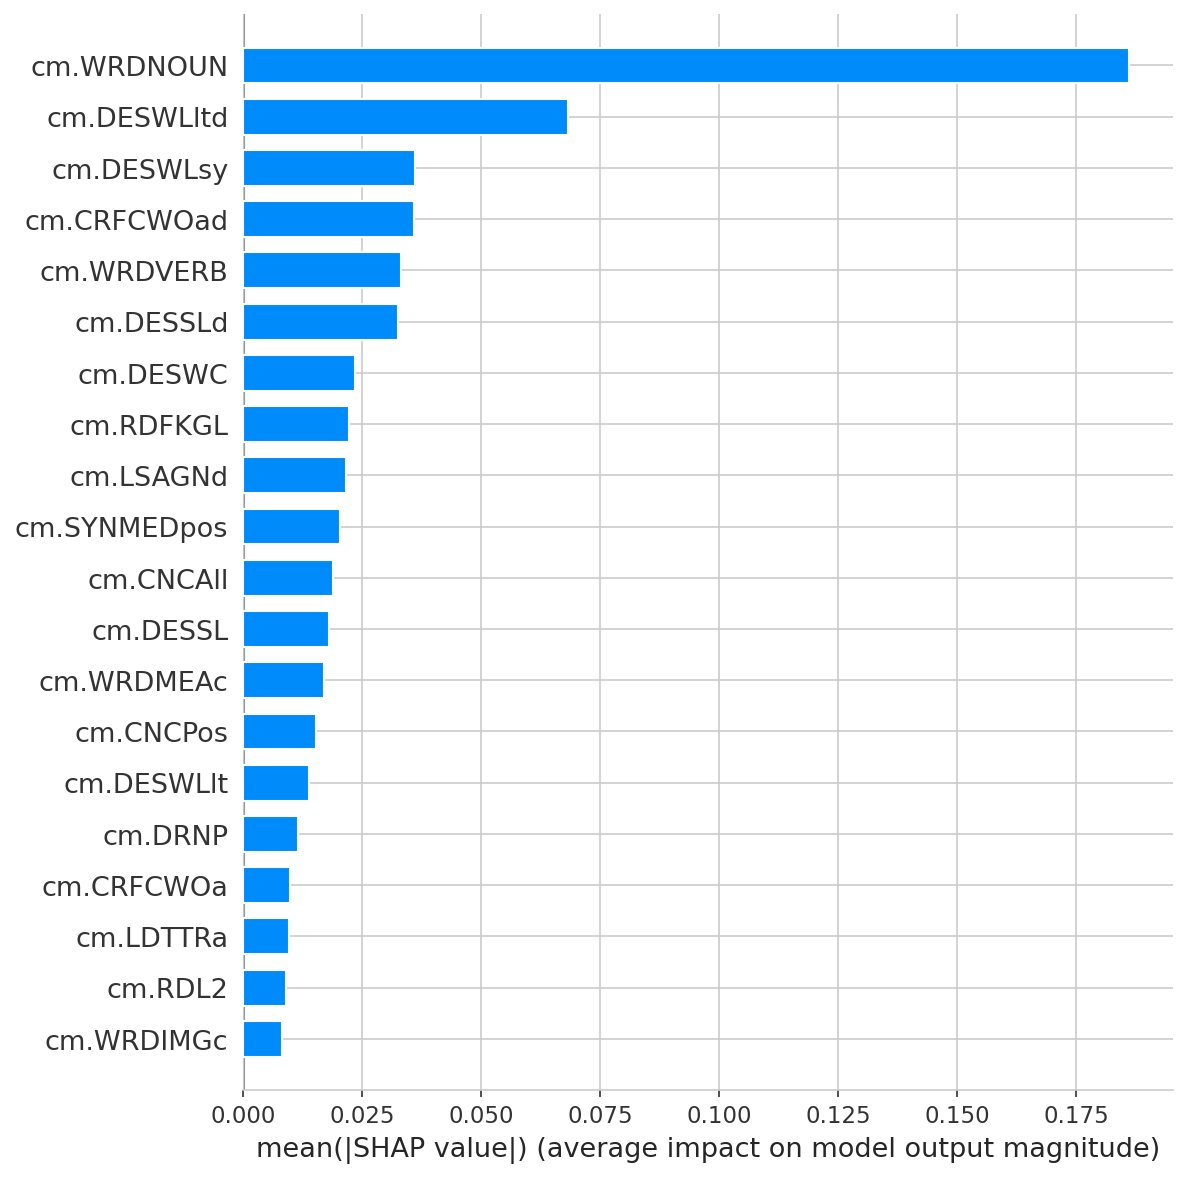

In [53]:
plt.figure(figsize = (15,8))
ax = shap.summary_plot(shap_values, 
                       datasetCurrent.columns,
                       plot_type='bar')
plt.show()

In [ ]:
type(shap_values)

shap._explanation.Explanation

In [ ]:
clustering = shap.utils.hclust(X_train, y_train)

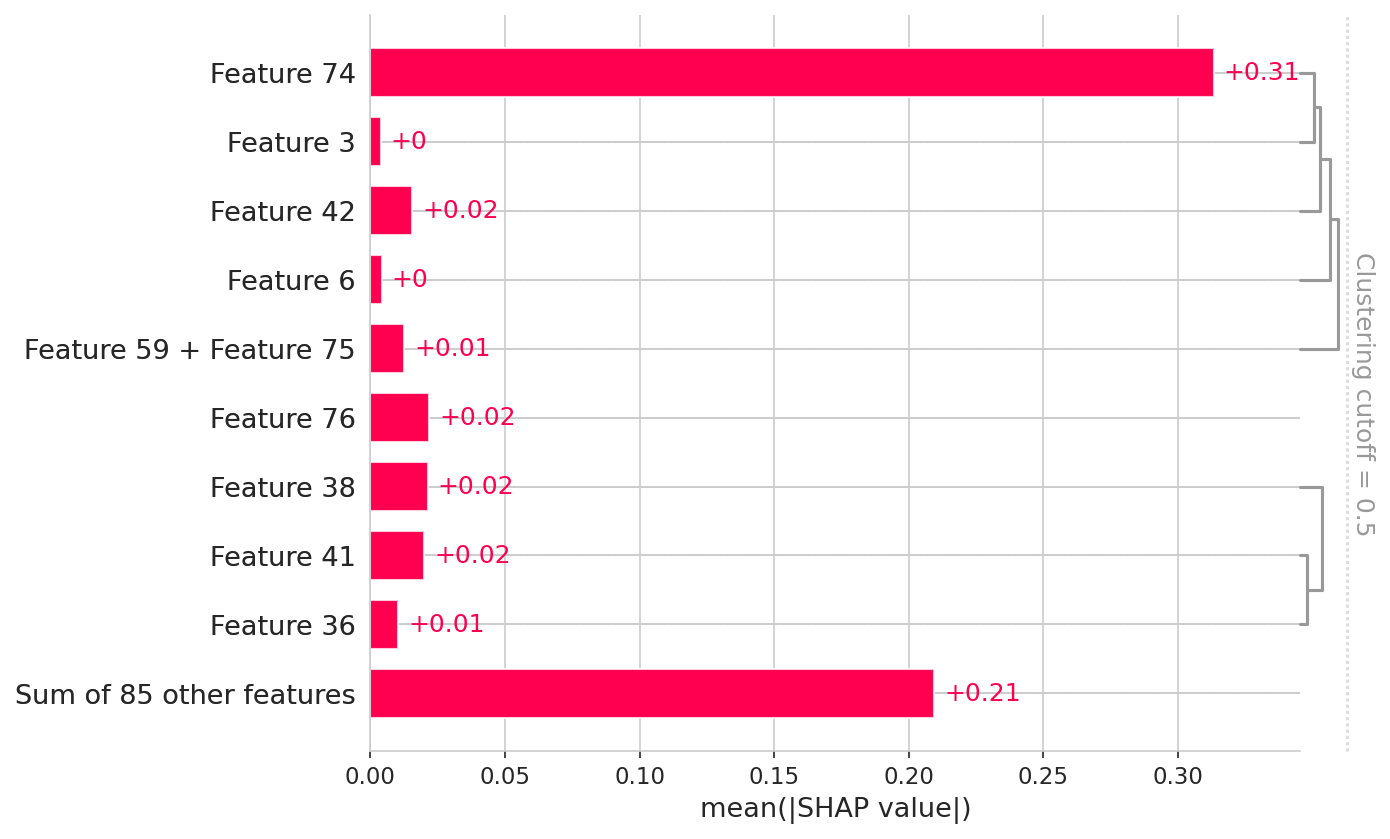

In [ ]:
shap.plots.bar(shap_values, clustering=clustering)

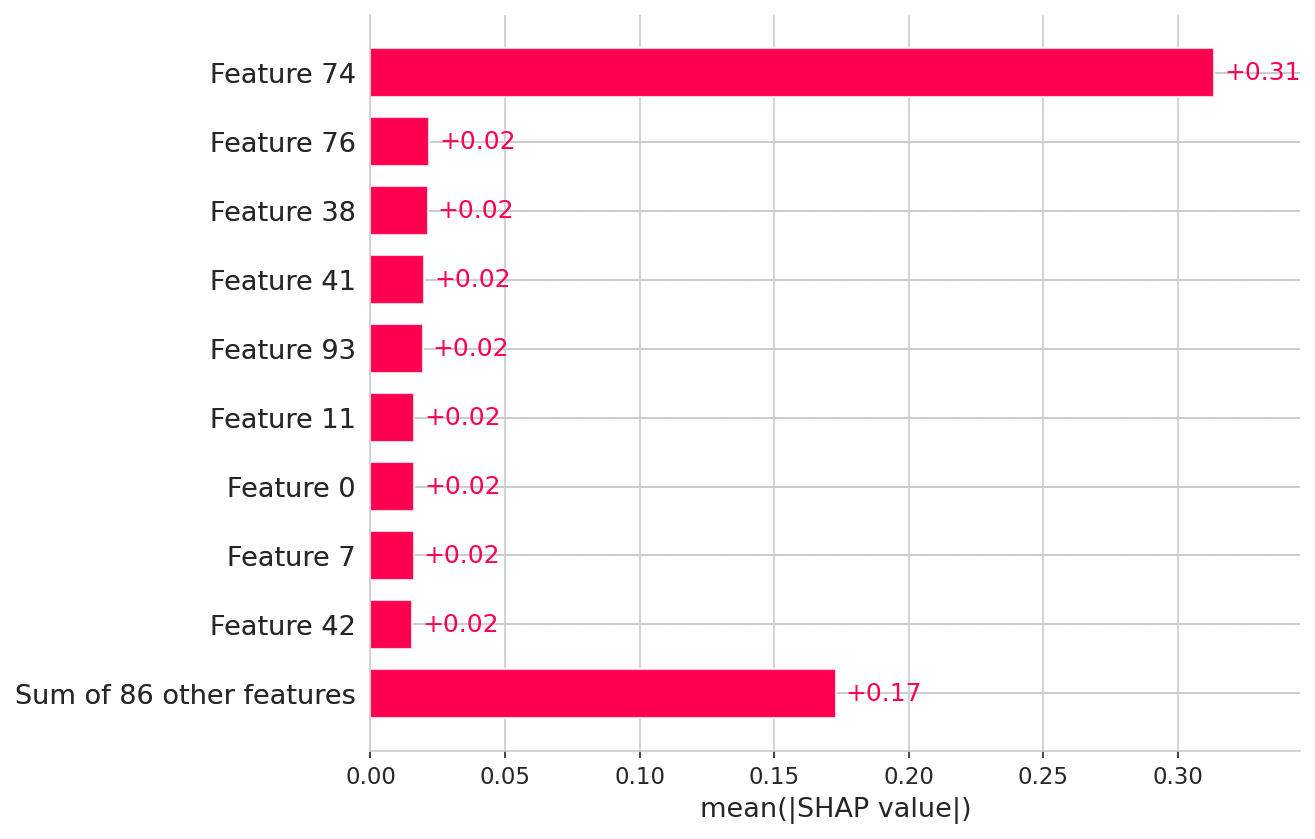

In [ ]:
shap.plots.bar(shap_values, max_display=10)

Cross Validation - Scikit-Learn's Random Forest Classifier

In [ ]:
#from sklearn.model_selection import cross_val_score
#rfc_cv = RandomForestClassifier(n_estimators=100)
#scores = cross_val_score(rfc_cv, X_train, y_train, cv=10, scoring = "accuracy")
#print("Scores:", scores)
#print("Mean:", scores.mean())
#print("Standard Deviation:", scores.std())

Scores: [0.96875    0.97916667 0.95833333 1.         0.98947368 0.98947368
 0.98947368 1.         0.96842105 0.98947368]
Mean: 0.9832565789473684
Standard Deviation: 0.013355609745452359


XGBoost

In [ ]:
#xgb_cv = XGBClassifier(n_estimators=100)
#scores = cross_val_score(xgb_cv, X_train, y_train, cv=10, scoring = "accuracy")
#print("Scores:", scores)
#print("Mean:", scores.mean())
#print("Standard Deviation:", scores.std())

Scores: [0.95348837 0.93023256 0.93023256 0.93023256 0.93023256 0.95348837
 0.95348837 0.95238095 1.         0.97619048]
Mean: 0.9509966777408637
Standard Deviation: 0.02186593140604478


The best parameters for prediction as found by the tuning tests are:

max_depth = 5
min_child_weight = 1
gamma = 0
subsample = 0.8
colsample_bytree = 0.8
reg_alpha = 0.005

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(datasetCurrent.drop('classe', axis=1), datasetCurrent['classe'],
                                                   test_size=0.33)

In [ ]:
xgboost = XGBClassifier(max_depth=5, learning_rate=0.01, n_estimators=100, gamma=0, 
                        min_child_weight=1, subsample=0.8, colsample_bytree=0.8, reg_alpha=0.005)

xgboost.fit(X_train, y_train)
preds = xgboost.predict(X_test)

accuracy = (preds == y_test).sum().astype(float) / len(preds)*100

print("XGBoost's prediction accuracy WITH optimal hyperparameters is: %3.2f" % (accuracy))

XGBoost's prediction accuracy WITH optimal hyperparameters is: 97.63


In [ ]:
xgb_cv = XGBClassifier(n_estimators=100)
scores = cross_val_score(xgb_cv, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.97674419 0.97674419 0.93023256 0.93023256 0.95348837 0.90697674
 0.93023256 0.97619048 0.88095238 0.92857143]
Mean: 0.9390365448504984
Standard Deviation: 0.03029299003555244


# XGBoost - Evaluation

In [ ]:
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

{0: 200, 1: 198}

In [ ]:
predictions = cross_val_predict(xgb, X_test, y_test, cv=5)
confusion_matrix(y_test, predictions)

array([[198,   2],
       [  8, 190]])

In [ ]:
print("Precision:", precision_score(y_test, predictions, average='micro'))
print("Recall:",recall_score(y_test, predictions, average='micro'))

Precision: 0.9748743718592965
Recall: 0.9748743718592965


In [ ]:
print("F1-Score:", f1_score(y_test, predictions, average='micro'))

F1-Score: 0.9748743718592965
